In [2]:
!pip install numba

Block size: 1
CPU grayscale conversion time: 0.2225 seconds
GPU grayscale conversion time (1D): 0.2731 seconds
GPU grayscale conversion time (2D): 0.2553 seconds


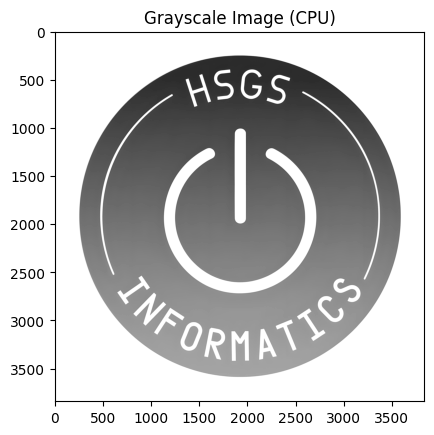

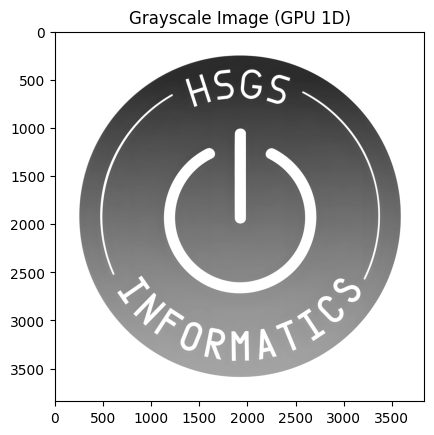

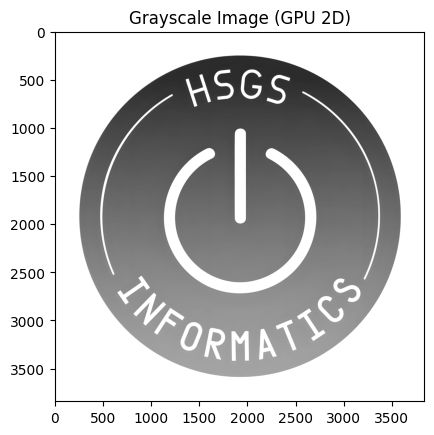

Block size: 4
CPU grayscale conversion time: 0.0849 seconds
GPU grayscale conversion time (1D): 0.0977 seconds
GPU grayscale conversion time (2D): 0.0973 seconds


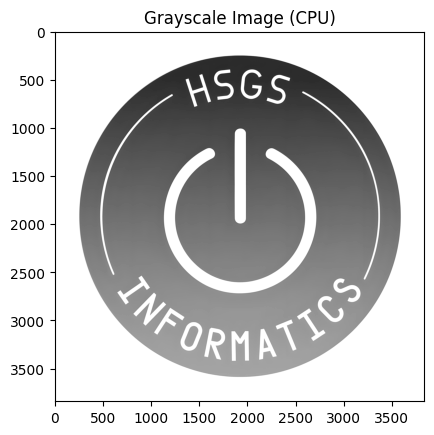

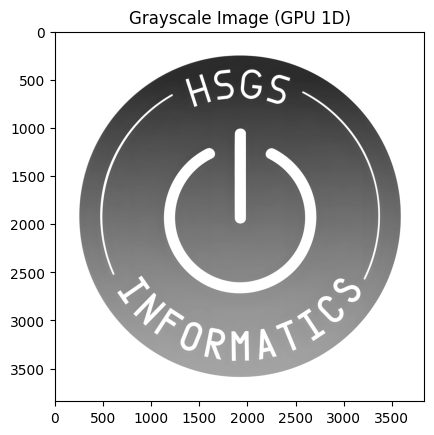

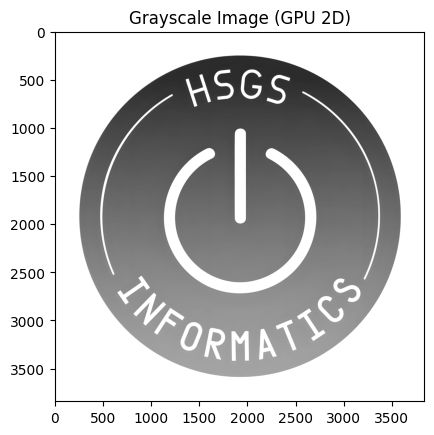

Block size: 16
CPU grayscale conversion time: 0.0843 seconds
GPU grayscale conversion time (1D): 0.0704 seconds
GPU grayscale conversion time (2D): 0.0658 seconds


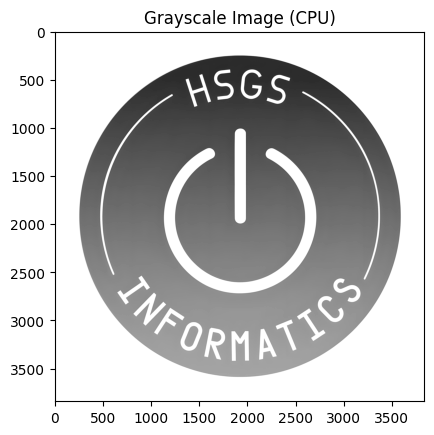

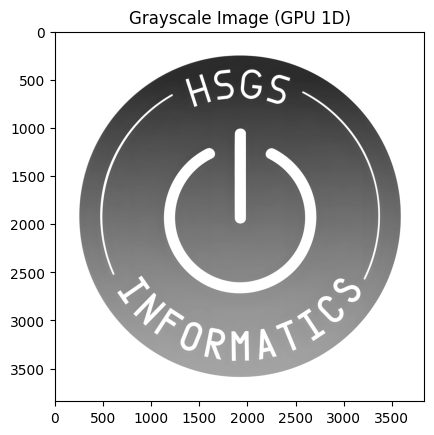

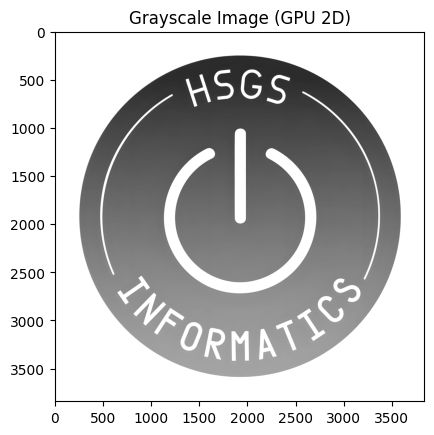

Block size: 64
CPU grayscale conversion time: 0.0850 seconds
GPU grayscale conversion time (1D): 0.0662 seconds
GPU grayscale conversion time (2D): 0.0635 seconds


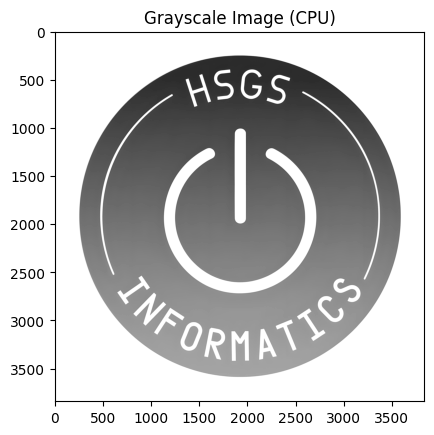

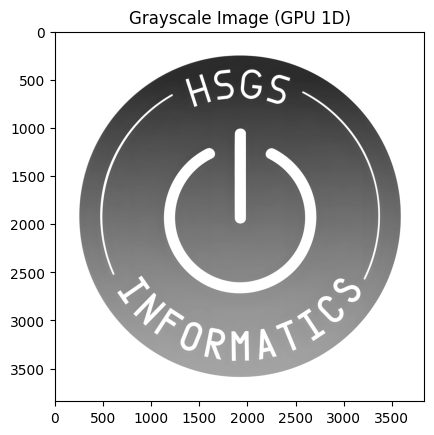

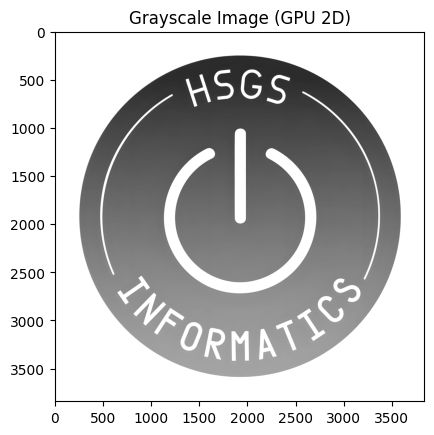

Block size: 256
CPU grayscale conversion time: 0.0825 seconds
GPU grayscale conversion time (1D): 0.0863 seconds
GPU grayscale conversion time (2D): 0.0897 seconds


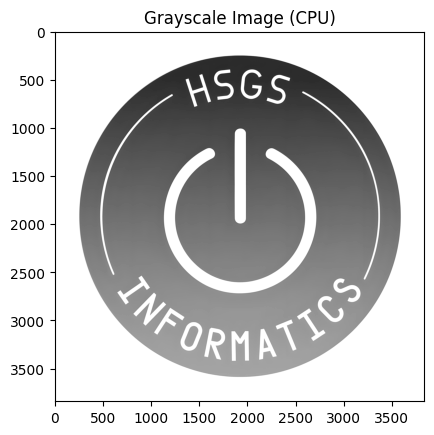

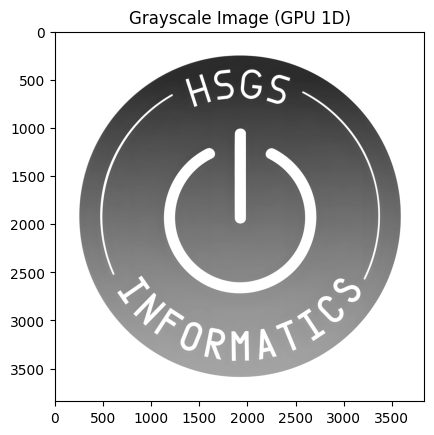

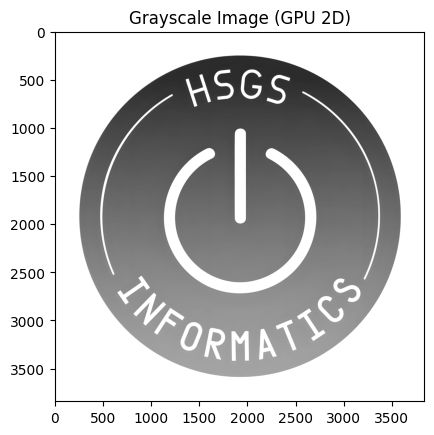

Block size: 1024
CPU grayscale conversion time: 0.0858 seconds
GPU grayscale conversion time (1D): 0.0647 seconds
GPU grayscale conversion time (2D): 0.0642 seconds


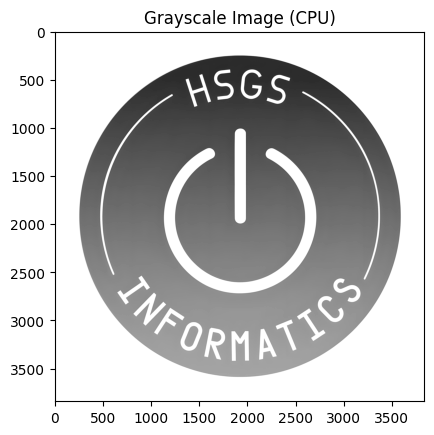

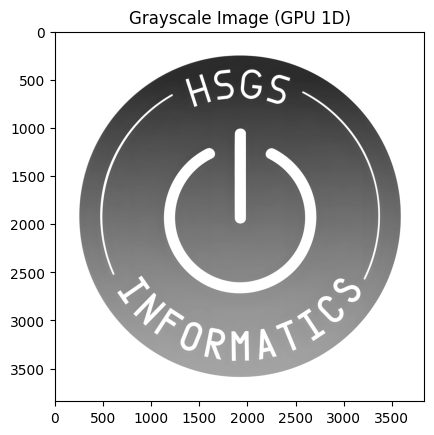

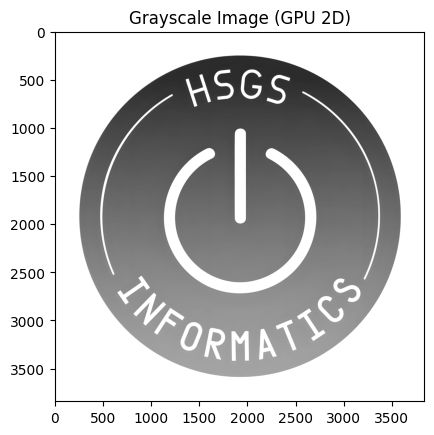

In [40]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, njit
import time

def load_image(path):
    return plt.imread(path).astype(np.float32)

def flatten_image(image):
    return image.reshape(-1, 3)

@njit
def to_grayscale_cpu(pixels):
    pixel_count = len(pixels)
    gray_pixels = np.empty(pixel_count)
    for i in range(pixel_count):
        r, g, b = pixels[i]
        gray_pixels[i] = 0.299 * r + 0.587 * g + 0.114 * b
    return gray_pixels

@cuda.jit
def to_grayscale_gpu_1d(pixels, gray_pixels):
    idx = cuda.grid(1)
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

@cuda.jit
def to_grayscale_gpu_2d(pixels, gray_pixels, width):
    x, y = cuda.grid(2)
    idx = x + y * width
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

def perform_gpu_conversion_1d(pixels, blocks_per_grid, threads_per_block):
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array(len(pixels), dtype=np.float32)
    to_grayscale_gpu_1d[blocks_per_grid, threads_per_block](pixels_gpu, gray_pixels_gpu)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def perform_gpu_conversion_2d(pixels, image_shape, threads_per_block):
    height, width, _ = image_shape
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array((height * width), dtype=np.float32)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    to_grayscale_gpu_2d[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](pixels_gpu, gray_pixels_gpu, width)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def measure_time(func, *args):
    start_time = time.time()
    result = func(*args)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def display_and_save_image(image, title, filename):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    plt.imsave(filename, image, cmap='gray')

def compare_grayscale_conversion(image_path, threads_per_block):
    image = load_image(image_path)
    pixels = flatten_image(image)

    gray_pixels_cpu, cpu_time = measure_time(to_grayscale_cpu, pixels)
    print(f'CPU grayscale conversion time: {cpu_time:.4f} seconds')

    blocks_per_grid = (len(pixels) + (threads_per_block - 1)) // threads_per_block
    gray_pixels_gpu_1d, gpu_1d_time = measure_time(perform_gpu_conversion_1d, pixels, blocks_per_grid, threads_per_block)
    print(f'GPU grayscale conversion time (1D): {gpu_1d_time:.4f} seconds')

    sqrt_block = int(math.sqrt(threads_per_block))

    gray_pixels_gpu_2d, gpu_2d_time = measure_time(perform_gpu_conversion_2d, pixels, image.shape, (sqrt_block, sqrt_block))
    print(f'GPU grayscale conversion time (2D): {gpu_2d_time:.4f} seconds')

    gray_image_cpu = gray_pixels_cpu.reshape(image.shape[0], image.shape[1])
    display_and_save_image(gray_image_cpu, 'Grayscale Image (CPU)', 'gray_cpu.png')
    gray_image_gpu_1d = gray_pixels_gpu_1d.reshape(image.shape[0], image.shape[1])
    display_and_save_image(gray_image_gpu_1d, 'Grayscale Image (GPU 1D)', 'gray_gpu_1d.png')
    gray_image_gpu_2d = gray_pixels_gpu_2d.reshape(image.shape[0], image.shape[1])
    display_and_save_image(gray_image_gpu_2d, 'Grayscale Image (GPU 2D)', 'gray_gpu_2d.png')


for i in (1 << (j << 1) for j in range(6)):
    print("Block size: " + str(i))
    compare_grayscale_conversion('unnamed.jpg', threads_per_block=i)

Running conversion for block size: 1 (1D) or 1 x 1 (2D)
Running conversion for block size: 4 (1D) or 2 x 2 (2D)
Running conversion for block size: 16 (1D) or 4 x 4 (2D)
Running conversion for block size: 64 (1D) or 8 x 8 (2D)
Running conversion for block size: 256 (1D) or 16 x 16 (2D)
Running conversion for block size: 1024 (1D) or 32 x 32 (2D)


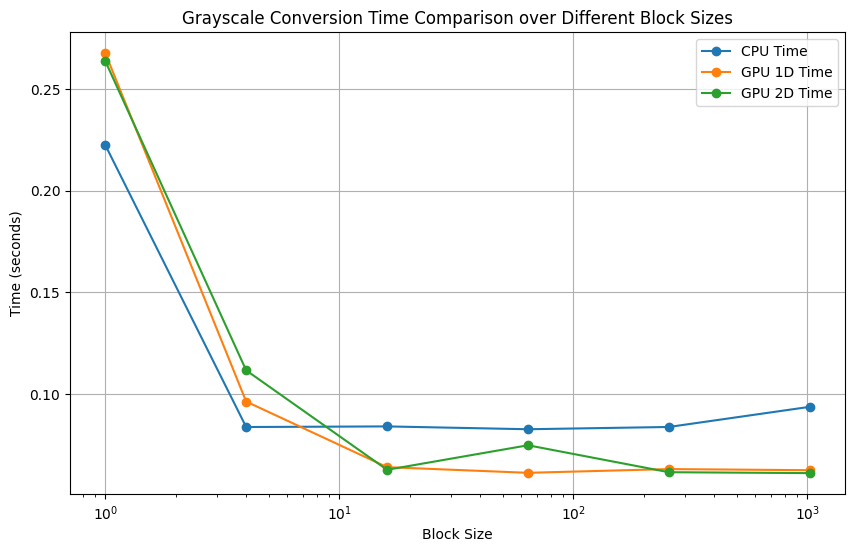

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, njit
import time

def load_image(path):
    return plt.imread(path).astype(np.float32)

def flatten_image(image):
    return image.reshape(-1, 3)

@njit
def to_grayscale_cpu(pixels):
    pixel_count = len(pixels)
    gray_pixels = np.empty(pixel_count)
    for i in range(pixel_count):
        r, g, b = pixels[i]
        gray_pixels[i] = 0.299 * r + 0.587 * g + 0.114 * b
    return gray_pixels

@cuda.jit
def to_grayscale_gpu_1d(pixels, gray_pixels):
    idx = cuda.grid(1)
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

@cuda.jit
def to_grayscale_gpu_2d(pixels, gray_pixels, width):
    x, y = cuda.grid(2)
    idx = x + y * width
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

def perform_gpu_conversion_1d(pixels, blocks_per_grid, threads_per_block):
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array(len(pixels), dtype=np.float32)
    to_grayscale_gpu_1d[blocks_per_grid, threads_per_block](pixels_gpu, gray_pixels_gpu)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def perform_gpu_conversion_2d(pixels, image_shape, threads_per_block):
    height, width, _ = image_shape
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array((height * width), dtype=np.float32)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    to_grayscale_gpu_2d[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](pixels_gpu, gray_pixels_gpu, width)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def measure_time(func, *args):
    start_time = time.time()
    result = func(*args)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def compare_grayscale_conversion(image_path, threads_per_block):
    image = load_image(image_path)
    pixels = flatten_image(image)

    gray_pixels_cpu, cpu_time = measure_time(to_grayscale_cpu, pixels)

    blocks_per_grid = (len(pixels) + (threads_per_block - 1)) // threads_per_block
    gray_pixels_gpu_1d, gpu_1d_time = measure_time(perform_gpu_conversion_1d, pixels, blocks_per_grid, threads_per_block)

    sqrt_block = int(threads_per_block ** 0.5)
    gray_pixels_gpu_2d, gpu_2d_time = measure_time(perform_gpu_conversion_2d, pixels, image.shape, (sqrt_block, sqrt_block))

    return cpu_time, gpu_1d_time, gpu_2d_time

def run_comparison_and_plot(image_path):
    block_sizes = [1 << (j << 1) for j in range(6)]
    cpu_times = []
    gpu_1d_times = []
    gpu_2d_times = []

    for threads_per_block in block_sizes:
        print(f"Running conversion for block size: {threads_per_block} (1D) or {(int)(threads_per_block**0.5)} x {(int)(threads_per_block**0.5)} (2D)")
        cpu_time, gpu_1d_time, gpu_2d_time = compare_grayscale_conversion(image_path, threads_per_block)
        cpu_times.append(cpu_time)
        gpu_1d_times.append(gpu_1d_time)
        gpu_2d_times.append(gpu_2d_time)

    plt.figure(figsize=(10, 6))
    plt.plot(block_sizes, cpu_times, label='CPU Time', marker='o')
    plt.plot(block_sizes, gpu_1d_times, label='GPU 1D Time', marker='o')
    plt.plot(block_sizes, gpu_2d_times, label='GPU 2D Time', marker='o')

    plt.xlabel('Block Size')
    plt.ylabel('Time (seconds)')
    plt.title('Grayscale Conversion Time Comparison over Different Block Sizes')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

run_comparison_and_plot('unnamed.jpg')